In [1]:
# -*- coding: UTF-8 -*-
import os
import torch
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# import torchvision.transforms.functional as F
import numpy as np
import pickle
import random
import os
import datetime
import pickle
import torch
from r_Encoders import *
from r_train_valid import *
import os
import torch
import numpy as np
import random
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset, Subset
import matplotlib.pyplot as plt
import argparse

In [2]:

# 查看当前工作目录
print("Current working directory:", os.getcwd())
# 如果不是项目的根目录，设置到正确的路径
os.chdir('/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main')
print("Changed working directory to:", os.getcwd())
# 示例数据
cls1_data_subjid = np.load("/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/fuse_sfMRI_ANI/fuse_sfMRI_ANI.npy", allow_pickle=True)
cls0_data_subjid = np.load("/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/fuse_sfMRI_control/fuse_sfMRI_control.npy", allow_pickle=True)
# 将 cls0_data_subjid 按第二维第0项排序
New_cls0_data_subjid = cls0_data_subjid[np.argsort(cls0_data_subjid[:, 0])]
New_cls1_data_subjid = cls1_data_subjid[np.argsort(cls1_data_subjid[:, 0])]



def load_fused_data(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

# 加载三个数据集
# file_paths = {
#     "HC": "/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/F_DTI/f_H_results.pkl",
#     "A": "/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/F_DTI/f_A_results.pkl",
#     "NO": "/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/F_DTI/f_NO_results.pkl",
# }
file_paths = {
    "HC": "/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/Youan_DTI/HC_DTI_Length.pkl",
    "A": "/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/Youan_DTI/ANI_DTI_Length.pkl",
    "NO": "/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/data/F_DTI/NOANI_FA.pkl",
}
labels = {"HC": 0, "A": 1, "NO": 1}  # 标签 (0：健康，1：异常)
cls0_DTI = load_fused_data(file_paths["HC"])
cls1_DTI = load_fused_data(file_paths["A"])

torch.set_printoptions(precision=4)

class get_Dataset(Dataset):
    def __init__(self, tr_data_subjid, tr_label, DTI_dict=None):  # 增加默认值 None
        super().__init__()
        self.DTI_dict = DTI_dict  # 正确初始化 DTI 字典

        subj_num = tr_data_subjid.shape[0]
        numbers = [int(x) for x in range(subj_num)]

        # (1) subject id
        d1 = zip(numbers, tr_data_subjid[:, 0])
        self.subjid_dict = dict(d1)

        # (2) fMRI data
        d2 = zip(numbers, tr_data_subjid[:, 1])
        self.fMRIseries_dict = dict(d2)
        self.full_subject_list = list(self.fMRIseries_dict.keys())

        # (3) sMRI traditional data
        norm_sMRI_trad_init = tr_data_subjid[:, 2]
        norm_sMRI_trad_lst = []
        for i in range(norm_sMRI_trad_init.shape[0]):
            norm_sMRI_trad_lst.append(norm_sMRI_trad_init[i])
        norm_sMRI_trad_arr = np.array(norm_sMRI_trad_lst)
        norm_sMRI_trad = (norm_sMRI_trad_arr - np.min(norm_sMRI_trad_arr, axis=0)) / (np.max(norm_sMRI_trad_arr, axis=0) - np.min(norm_sMRI_trad_arr, axis=0))
        d3 = zip(numbers, norm_sMRI_trad)
        self.sMRI_trad_dict = dict(d3)

        # (4) sMRI deep brainspace (256, 256, 256)
        d4 = zip(numbers, tr_data_subjid[:, 3])
        self.sMRI_deep_brainspace_dict = dict(d4)

        # (5) sMRI deep mnispace (181, 217, 181)
        d5 = zip(numbers, tr_data_subjid[:, 4])
        self.sMRI_deep_mnispace_dict = dict(d5)

        # (6) label
        d6 = zip(numbers, tr_label)  # tr_label is corresponding label
        self.behavioral_dict = dict(d6)

    def __len__(self):
        return len(self.full_subject_list)

    def __getitem__(self, idx):
        subject = self.full_subject_list[idx]
        label = self.behavioral_dict[int(subject)]

        subjid = self.subjid_dict[int(subject)]
        fMRI_timeseries = self.fMRIseries_dict[subject]
        sMRI_trad_freesurfer = self.sMRI_trad_dict[subject].astype('float64')
        sMRI_deep_brainspace = self.sMRI_deep_brainspace_dict[subject].astype('float64')
        sMRI_deep_mnispace = self.sMRI_deep_mnispace_dict[subject].astype('float64')

        # 获取对应的 DTI 数据
        if self.DTI_dict and subjid in self.DTI_dict:
            DTI_data = self.DTI_dict[subjid]
            DTI_data = torch.tensor(DTI_data).clone().detach()
        else:
            DTI_data = None

        # 转换标签为 Tensor
        if label == 0.0:
            label = torch.tensor(0).clone().detach()
        elif label == 1.0:
            label = torch.tensor(1).clone().detach()
        else:
            raise ValueError("Unexpected label value")

        return {
            'idx': subject,
            'subjid:': subjid,
            'fMRI': torch.tensor(fMRI_timeseries, dtype=torch.float32).clone().detach(),
            'sMRI_trad': torch.tensor(sMRI_trad_freesurfer, dtype=torch.float32).clone().detach(),
            'sMRI_deep_brainspace': torch.tensor(sMRI_deep_brainspace, dtype=torch.float32).clone().detach(),
            'sMRI_deep_mnispace': torch.tensor(sMRI_deep_mnispace, dtype=torch.float32).clone().detach(),
            'DTI': DTI_data,
            'label': label.clone().detach().float()
        }


cls0_label = np.zeros(New_cls0_data_subjid.shape[0])
cls1_label = np.ones(New_cls1_data_subjid.shape[0])

cls0_data = get_Dataset(New_cls0_data_subjid,cls0_label,cls0_DTI)
cls1_data = get_Dataset(New_cls1_data_subjid,cls1_label,cls1_DTI)


Current working directory: /root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/RMLA_HIV
Changed working directory to: /root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main


In [3]:

args = argparse.Namespace(
    dataset="HIVC",  # 数据集名称
    modulation='Normal',  # 调制方法
    fusion_method='concat',  # 融合方法
    batch_size=6,  # 每个批次的数据量
    epochs=70,  # 训练的总轮次
    optimizer='Adam',  # 优化器，可以是 SGD 或 Adam
    learning_rate=0.0006,  # 初始学习率
    lr_decay_step=35,  # 学习率衰减的起始步数
    lr_decay_ratio=0.00000001,  # 学习率衰减系数
    modulation_starts=0,  # 调制开始的训练轮次
    modulation_ends=100,  # 调制结束的训练轮次
    alpha=0.3,  # OGM-GE 调制中的 alpha 参数
    ckpt_path='/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/Models',  # 保存训练模型的路径
    train=True,  # 是否启用训练模式
    use_tensorboard=True,  # 是否启用 TensorBoard
    tensorboard_path="/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/tensor_board",  # TensorBoard 日志保存路径
    random_seed=0,  # 设置随机种子
    gpu_ids="3",  # GPU IDs
    lorb='m3ae',  # 模型选择
    gs_flag=True,  # 是否启用 GS 模式
    av_alpha=0.5,  # 音频和视觉模态融合时的 alpha 参数
    cav_opti=False,  # 是否启用 CAV 优化
    cav_lrs=False,  # 是否使用不同学习率
    cav_augnois=False,  # 是否应用数据增强噪声
    modal3=True,  # 是否启用三模态融合
    dynamic=True,  # 是否启用动态融合
    a_alpha=0.35,  # 三模态融合中的音频模态权重 alpha
    v_alpha=0.25,  # 三模态融合中的视觉模态权重 alpha
    t_alpha=0.4,  # 三模态融合中的文本模态权重 alpha
    ckpt_load_path_train=None  # 训练时加载的检查点路径
)
# 打印检查获取到的参数
print(args)


Namespace(dataset='HIVC', modulation='Normal', fusion_method='concat', batch_size=6, epochs=70, optimizer='Adam', learning_rate=0.0006, lr_decay_step=35, lr_decay_ratio=1e-08, modulation_starts=0, modulation_ends=100, alpha=0.3, ckpt_path='/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/Models', train=True, use_tensorboard=True, tensorboard_path='/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/tensor_board', random_seed=0, gpu_ids='3', lorb='m3ae', gs_flag=True, av_alpha=0.5, cav_opti=False, cav_lrs=False, cav_augnois=False, modal3=True, dynamic=True, a_alpha=0.35, v_alpha=0.25, t_alpha=0.4, ckpt_load_path_train=None)



Starting Fold 1/3
Training set size: 91, Validation set size: 46

Epoch 1/70 for Fold 1
Training with 15 batches, Validation with 7 batches
Start training ... 
这次训练集训练已结束！
Start RNP_training ... 
RNP_Training finished.

[Epoch 1/70] rnp_fMRI Loss: 0.0401, rnp_DTI Loss: 19.0549, rnp_sMRI Loss: 11.6182,

[Epoch 1/70] Training Loss: 14.4979, fMRI Loss: 6.6547, DTI Loss: 6.9865, sMRI Loss: 0.8568
Fusion Accuracy: 0.4048, AUC: 0.4941, F1 Score: 0.2713, Sensitivity: 0.4048, Specificity: 0.0400, Precision: 0.4595
fMRI Accuracy: 0.5952, DTI Accuracy: 0.5714, sMRI Accuracy: 0.4048

The best model has been saved at /root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/Models/best_model_fold_1_epoch_1_acc_0.4048.pth
Loss: 14.498, Acc: 0.405
fMRI Acc: 0.595, DTI Acc: 0.571, sMRI Acc: 0.405

Epoch 2/70 for Fold 1
Training with 15 batches, Validation with 7 batches
Start training ... 
这次训练集训练已结束！
Start RNP_training ... 
RNP_Training finished.

[Epoch 2/70] rnp_fMRI Loss: 0.0323, rnp_D

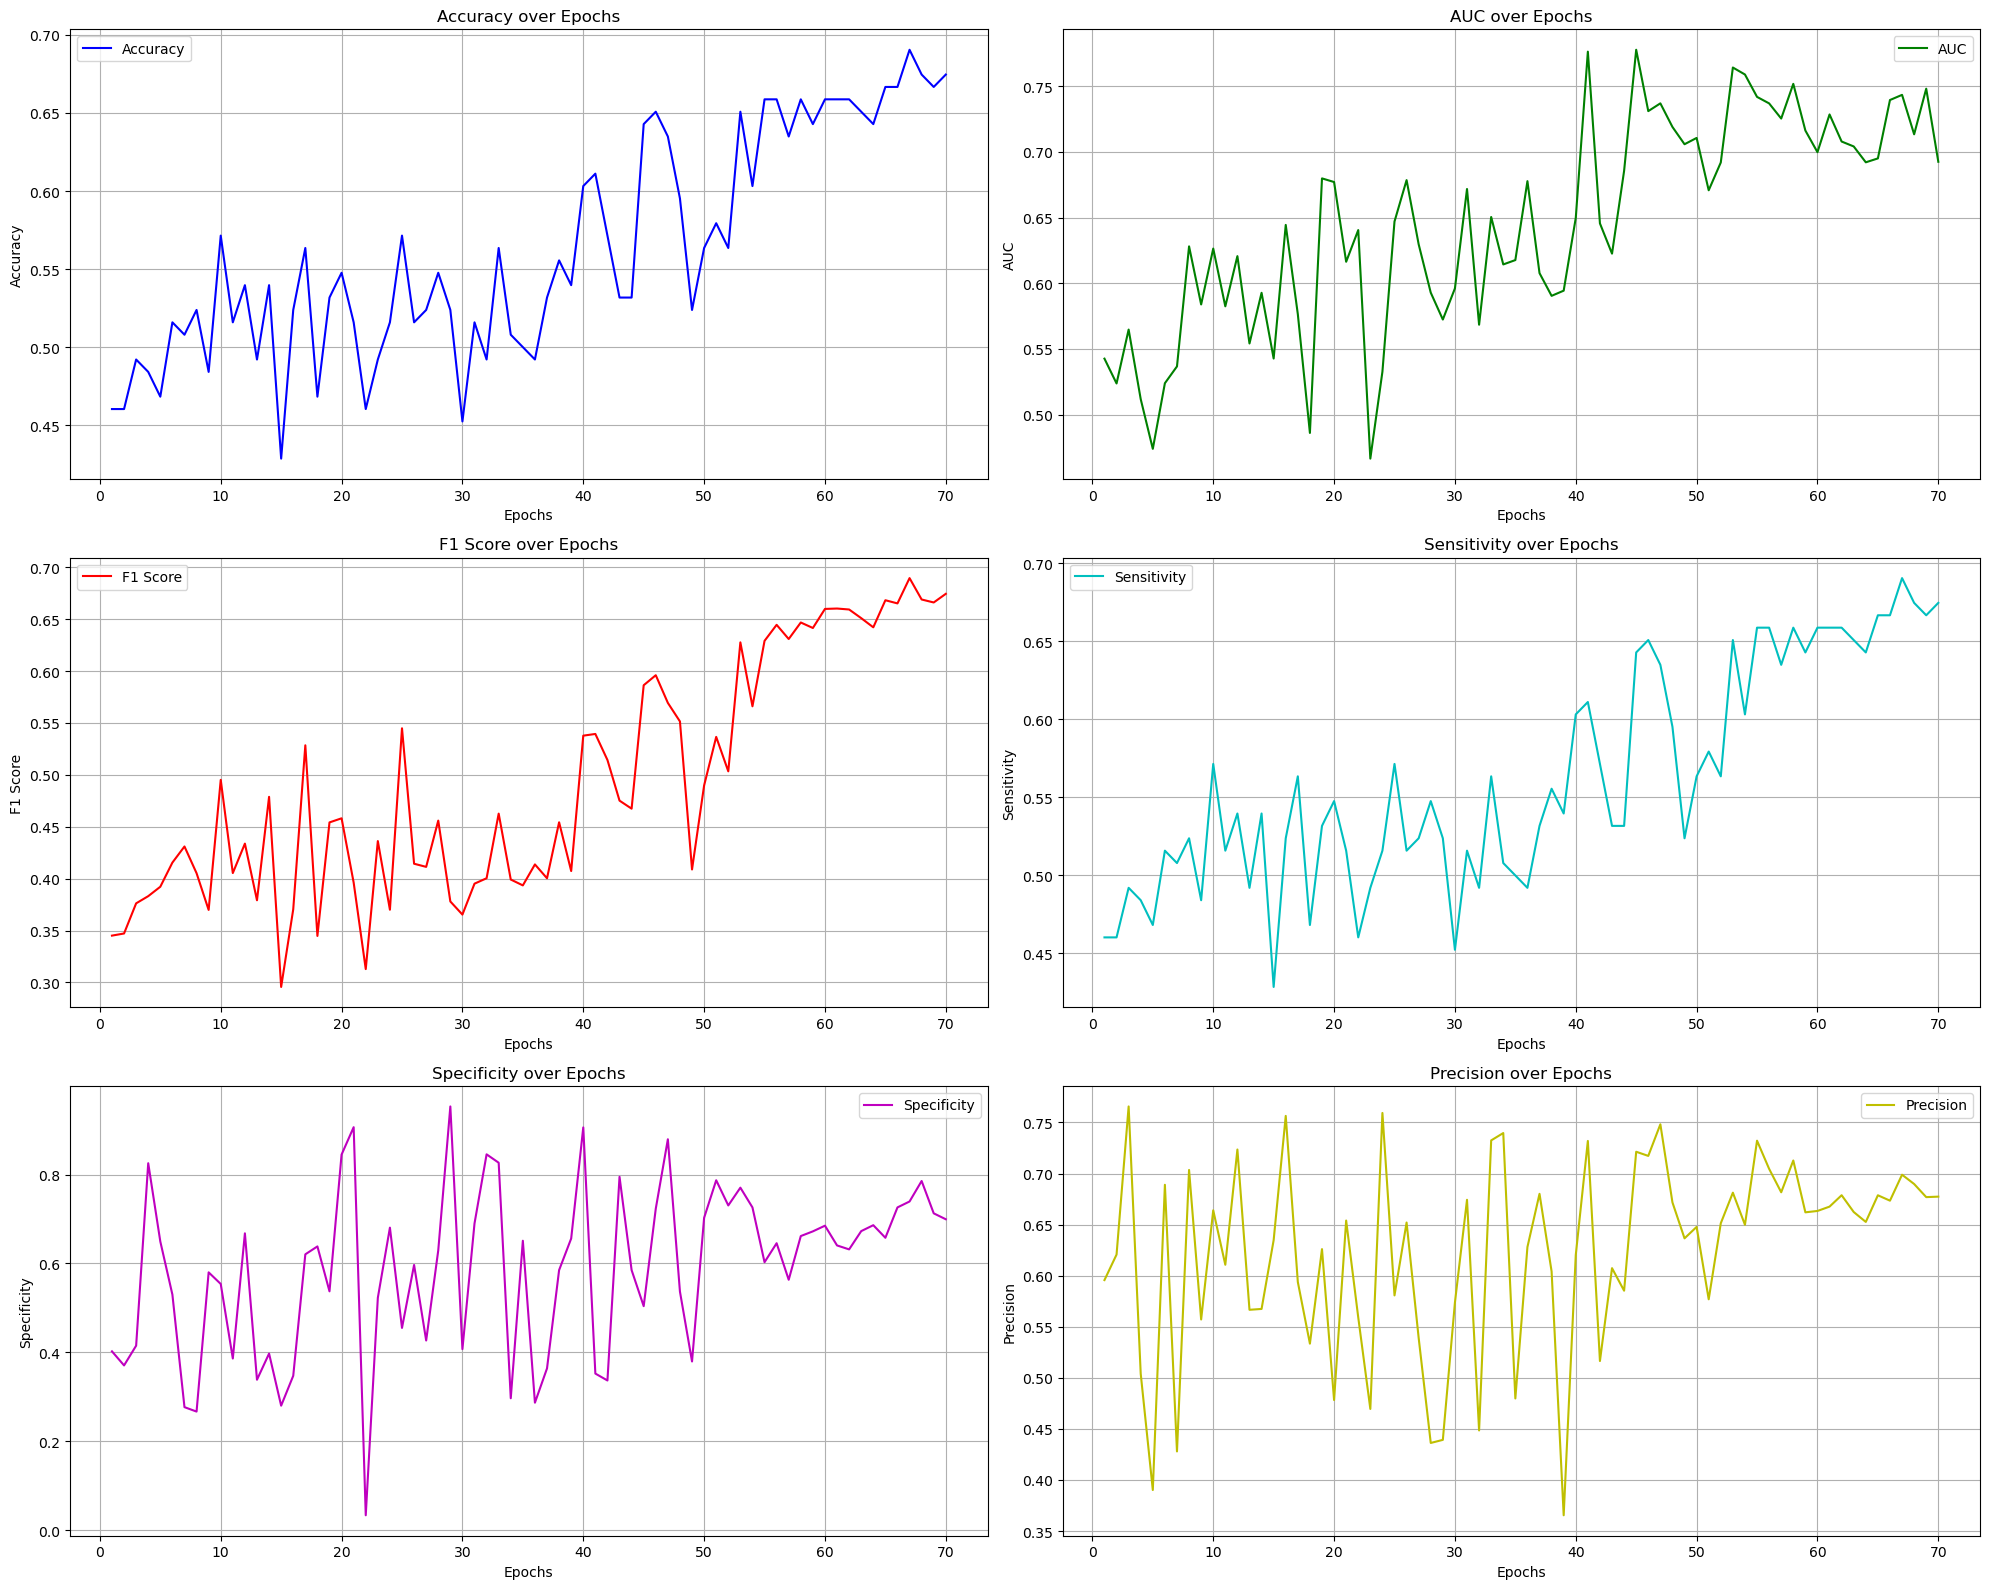

In [4]:
# 设置随机种子，确保实验的可重复性
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(args.random_seed)

# 设置使用的 GPU
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_ids
device = torch.device('cuda:0')

# 三折交叉验证设置
kf = KFold(n_splits=3, shuffle=True, random_state=args.random_seed)

# 假设你已经定义了 `get_Dataset` 类并实例化了 cls0_data 和 cls1_data
cls0_label = np.zeros(New_cls0_data_subjid.shape[0])
cls1_label = np.ones(New_cls1_data_subjid.shape[0])

cls0_data = get_Dataset(New_cls0_data_subjid, cls0_label, cls0_DTI)
cls1_data = get_Dataset(New_cls1_data_subjid, cls1_label, cls1_DTI)

# 合并两个类别的数据集
combined_dataset = ConcatDataset([cls0_data, cls1_data])

# 初始化历史记录为 None
txt_history = None
img_history = None
audio_history = None

# 初始化最佳精度
best_acc = 0.0

# 记录指标的历史
accuracy_history, auc_history = [], []
f1_history, sen_history = [], []
spe_history, pre_history = [], []

fold_idx = 1
for train_index, test_index in kf.split(range(len(combined_dataset))):
    print(f'\nStarting Fold {fold_idx}/{kf.n_splits}')
    print(f'Training set size: {len(train_index)}, Validation set size: {len(test_index)}')

    # 使用 Subset 根据索引划分训练集和测试集
    train_dataset = Subset(combined_dataset, train_index)
    test_dataset = Subset(combined_dataset, test_index)

    # 数据加载器
    train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, drop_last=True)

    # 重新实例化模型、优化器和学习率调度器，以确保每一折都是从头开始
    model = Modal3Classifier(args)
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, betas=(0.9, 0.999), weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=65, eta_min=1e-20)
    rnp_model = MultiModalRNPModel()
    rnp_model.to(device)

    gs = GSPlugin()
    rnp_flag = 0

    for epoch in range(args.epochs):
        print(f'\nEpoch {epoch+1}/{args.epochs} for Fold {fold_idx}')
        print(f'Training with {len(train_dataloader)} batches, Validation with {len(test_dataloader)} batches')

        # 调用训练函数进行训练
        batch_loss, batch_loss_f, batch_loss_d, batch_loss_s = train_epoch(
            args, epoch, model, device, train_dataloader, optimizer, scheduler, 
            gs_plugin=gs, gs_flag=args.gs_flag, av_alpha=0.5, 
            txt_history=txt_history, img_history=img_history, audio_history=audio_history)
        print("这次训练集训练已结束！")

        if rnp_flag == 0:
            rnp_loss_f, rnp_loss_d, rnp_loss_s = train_RNP(model, device, train_dataloader, rnp_model, learning_rate=0.001)
            print(f"\n[Epoch {epoch+1}/{args.epochs}] rnp_fMRI Loss: {rnp_loss_f:.4f}, rnp_DTI Loss: {rnp_loss_d:.4f}, rnp_sMRI Loss: {rnp_loss_s:.4f},")
        else:
            print("无需rnp训练")

        print(f"\n[Epoch {epoch+1}/{args.epochs}] Training Loss: {batch_loss:.4f}, fMRI Loss: {batch_loss_f:.4f}, DTI Loss: {batch_loss_d:.4f}, sMRI Loss: {batch_loss_s:.4f}")

        # 调用验证函数评估模型的表现
        acc, auc, f1, sen, spe, pre, acc_f, acc_d, acc_s = rnp_valid_pro(
            args, model, device, test_dataloader, rnp_model, gs_flag=args.gs_flag)

        # 记录指标
        accuracy_history.append(acc)
        auc_history.append(auc)
        f1_history.append(f1)
        sen_history.append(sen)
        spe_history.append(spe)
        pre_history.append(pre)

        # 打印验证结果
        print(f"Fusion Accuracy: {acc:.4f}, AUC: {auc:.4f}, F1 Score: {f1:.4f}, Sensitivity: {sen:.4f}, Specificity: {spe:.4f}, Precision: {pre:.4f}")
        print(f"fMRI Accuracy: {acc_f:.4f}, DTI Accuracy: {acc_d:.4f}, sMRI Accuracy: {acc_s:.4f}")

        # 保存模型
        if acc > best_acc:
            best_acc = float(acc)
            if not os.path.exists(args.ckpt_path):
                os.mkdir(args.ckpt_path)

            model_name = f'best_model_fold_{fold_idx}_epoch_{epoch+1}_acc_{acc:.4f}.pth'
            save_dir = os.path.join(args.ckpt_path, model_name)
            torch.save({
                'saved_epoch': epoch, 
                'model': model.state_dict(), 
                'optimizer': optimizer.state_dict(), 
                'scheduler': scheduler.state_dict()
            }, save_dir)
            rnp_model_name = f'best_rnp_model_fold_{fold_idx}_epoch_{epoch+1}_acc_{acc:.4f}.pth'
            rnp_save_dir = os.path.join(args.ckpt_path, rnp_model_name)
            torch.save({
                'saved_epoch': epoch, 
                'model': rnp_model.state_dict(), 
            }, rnp_save_dir)
            print(f'\nThe best model has been saved at {save_dir}')
            print(f"Loss: {batch_loss:.3f}, Acc: {acc:.3f}")
            print(f"fMRI Acc: {acc_f:.3f}, DTI Acc: {acc_d:.3f}, sMRI Acc: {acc_s:.3f}")
        else:
            print(f"\nLoss: {batch_loss:.3f}, Acc: {acc:.3f}, Best Acc: {best_acc:.3f}")
            print(f"fMRI Acc: {acc_f:.3f}, DTI Acc: {acc_d:.3f}, sMRI Acc: {acc_s:.3f}")

    del model, optimizer, scheduler, train_dataloader, test_dataloader, rnp_model
    torch.cuda.empty_cache()
    fold_idx += 1 

# 绘制验证过程中的指标变化图
# 3个Fold的平均值
num_epochs = 70
accuracy_avg = [np.mean(accuracy_history[i::num_epochs]) for i in range(num_epochs)]
auc_avg = [np.mean(auc_history[i::num_epochs]) for i in range(num_epochs)]
f1_avg = [np.mean(f1_history[i::num_epochs]) for i in range(num_epochs)]
sen_avg = [np.mean(sen_history[i::num_epochs]) for i in range(num_epochs)]
spe_avg = [np.mean(spe_history[i::num_epochs]) for i in range(num_epochs)]
pre_avg = [np.mean(pre_history[i::num_epochs]) for i in range(num_epochs)]
# 3个Fold的标准差
accuracy_std = [np.std(accuracy_history[i::num_epochs]) for i in range(num_epochs)]
auc_std = [np.std(auc_history[i::num_epochs]) for i in range(num_epochs)]
f1_std = [np.std(f1_history[i::num_epochs]) for i in range(num_epochs)]
sen_std = [np.std(sen_history[i::num_epochs]) for i in range(num_epochs)]
spe_std = [np.std(spe_history[i::num_epochs]) for i in range(num_epochs)]
pre_std = [np.std(pre_history[i::num_epochs]) for i in range(num_epochs)]
# 绘制每个指标的图像
metrics = {
    'Accuracy': accuracy_avg,
    'AUC': auc_avg,
    'F1 Score': f1_avg,
    'Sensitivity': sen_avg,
    'Specificity': spe_avg,
    'Precision': pre_avg
}

colors = ['b', 'g', 'r', 'c', 'm', 'y']  # 为每个指标指定不同的颜色

plt.figure(figsize=(20, 16))
for idx, (metric_name, metric_values) in enumerate(metrics.items()):
    plt.subplot(3, 2, idx + 1)
    plt.plot(range(1, num_epochs + 1), metric_values, color=colors[idx], label=metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('validation_metrics_average.png')
plt.show()

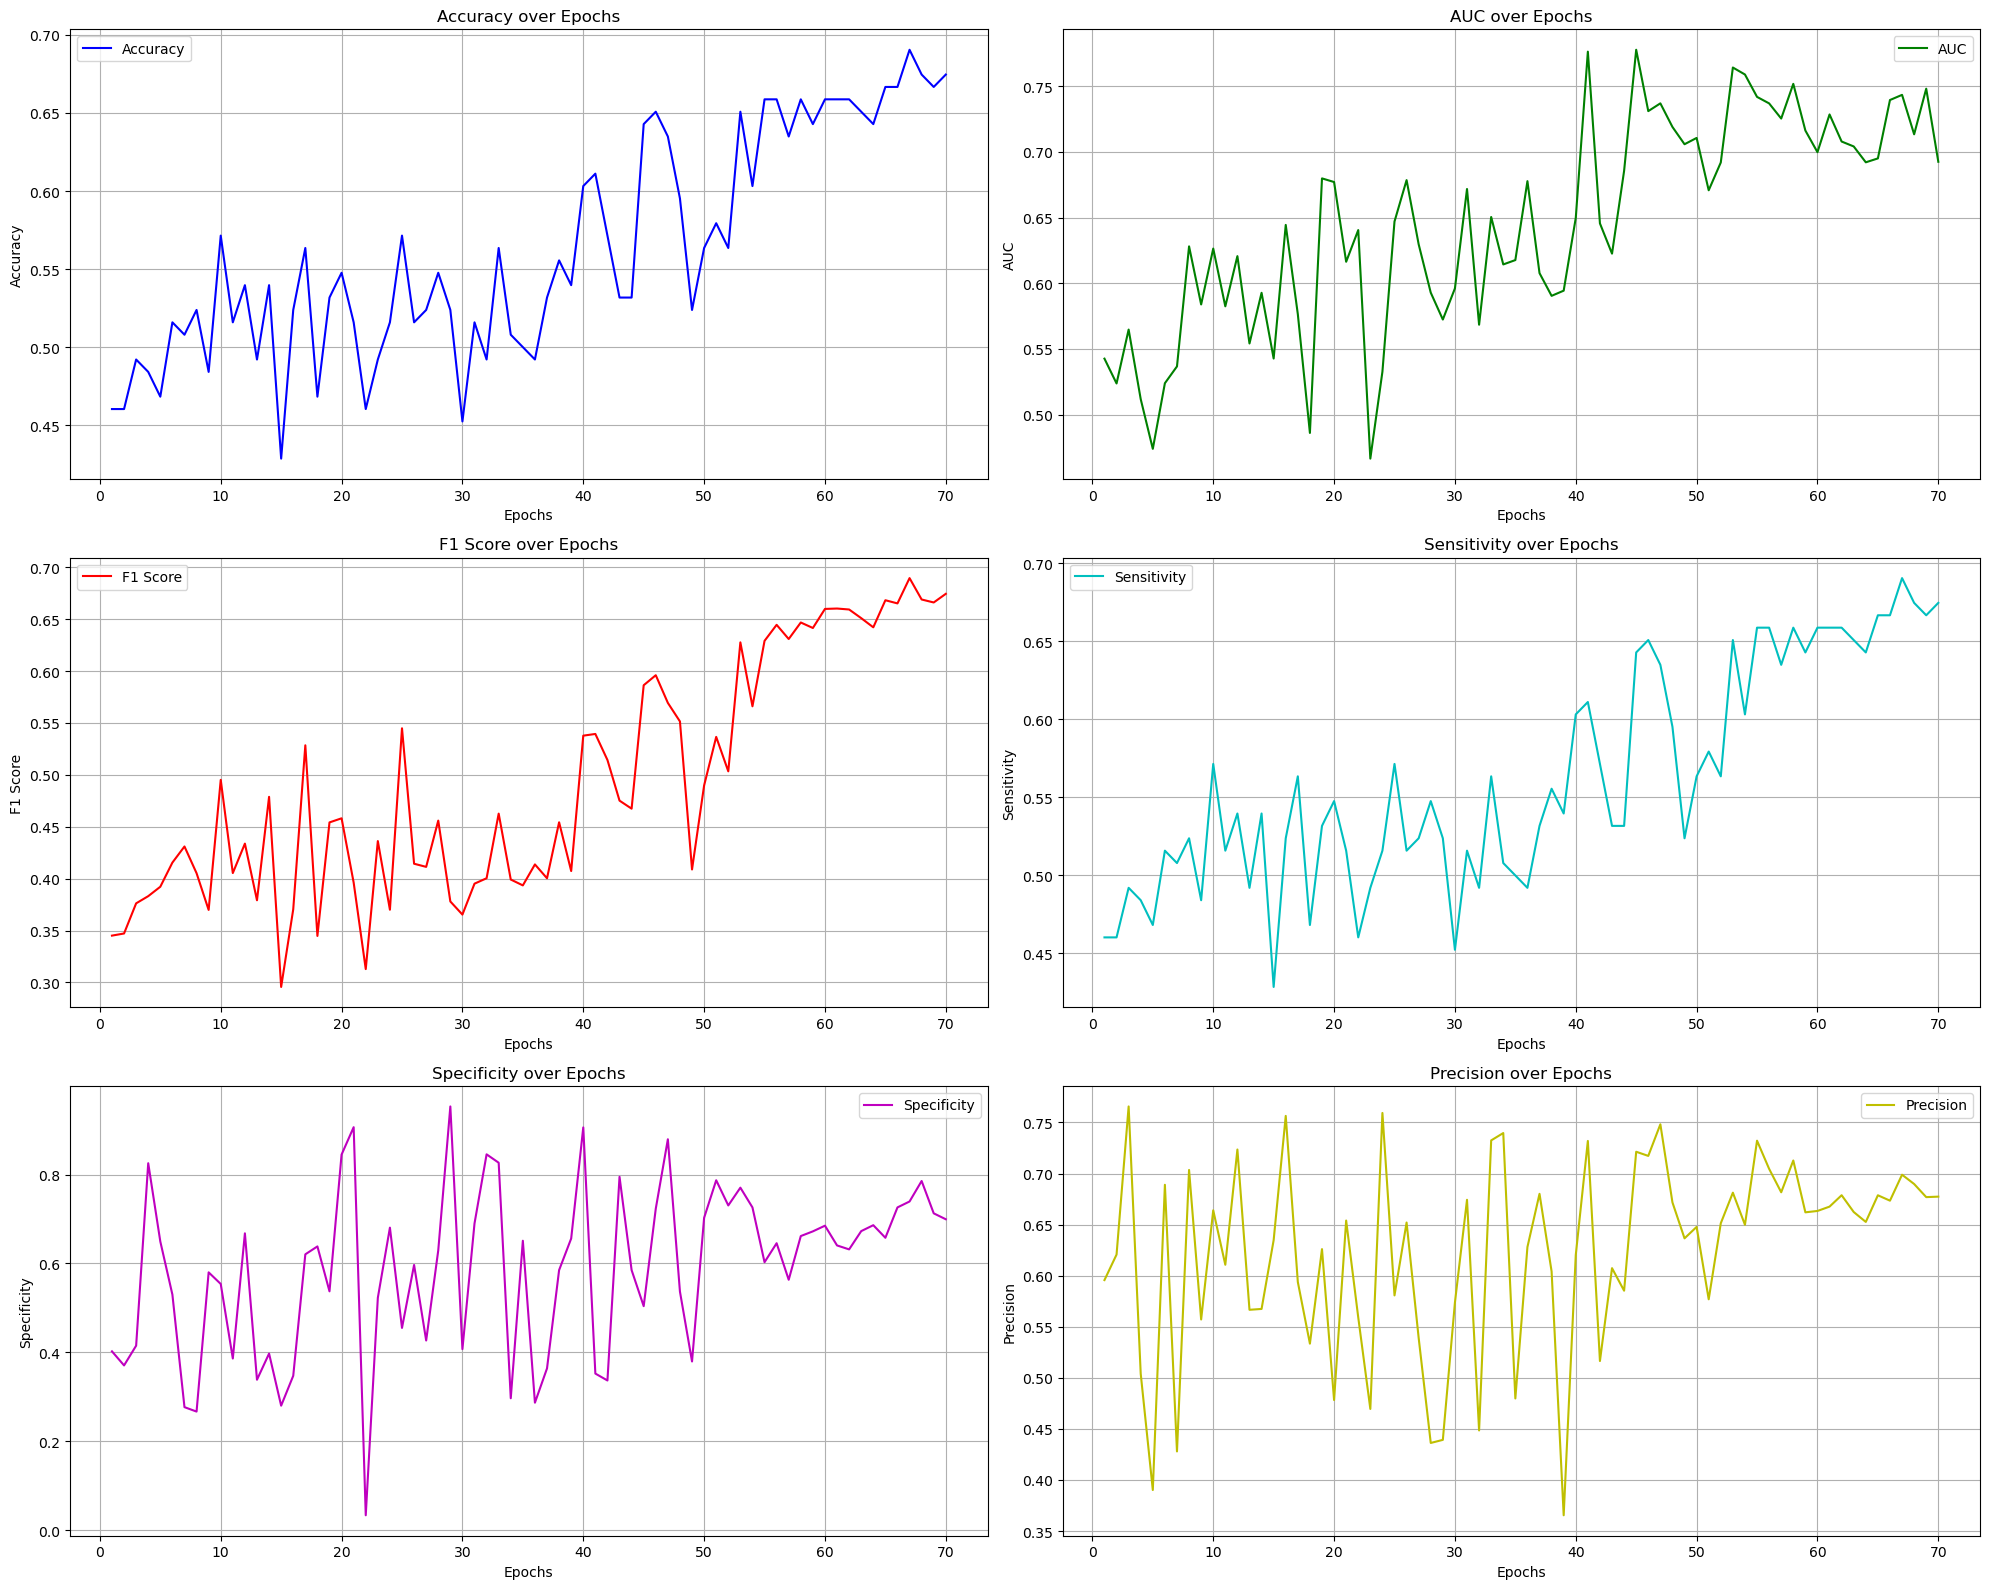

In [5]:
metrics = {
    'Accuracy': accuracy_avg,
    'AUC': auc_avg,
    'F1 Score': f1_avg,
    'Sensitivity': sen_avg,
    'Specificity': spe_avg,
    'Precision': pre_avg
}

colors = ['b', 'g', 'r', 'c', 'm', 'y']  # 为每个指标指定不同的颜色

plt.figure(figsize=(20, 16))
for idx, (metric_name, metric_values) in enumerate(metrics.items()):
    plt.subplot(3, 2, idx + 1)
    plt.plot(range(1, num_epochs + 1), metric_values, color=colors[idx], label=metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('validation_metrics_average.png')
plt.show()

In [6]:
# 假设你有一个 metrics 字典
metrics_History = {
    'Accuracy': accuracy_history,
    'AUC': auc_history,
    'F1 Score': f1_history,
    'Sensitivity': sen_history,
    'Specificity': spe_history,
    'Precision': pre_history
}
import json
# 保存到指定路径的 JSON 文件
file_path = '/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/IK_TriAUT_CRNP/Tri_AUT_CRNP_matrices_history.json'
with open(file_path, 'w') as json_file:
    json.dump(metrics_History, json_file)

print(f"Metrics saved to {file_path}")

Metrics saved to /root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/IK_TriAUT_CRNP/Tri_AUT_CRNP_matrices_history.json


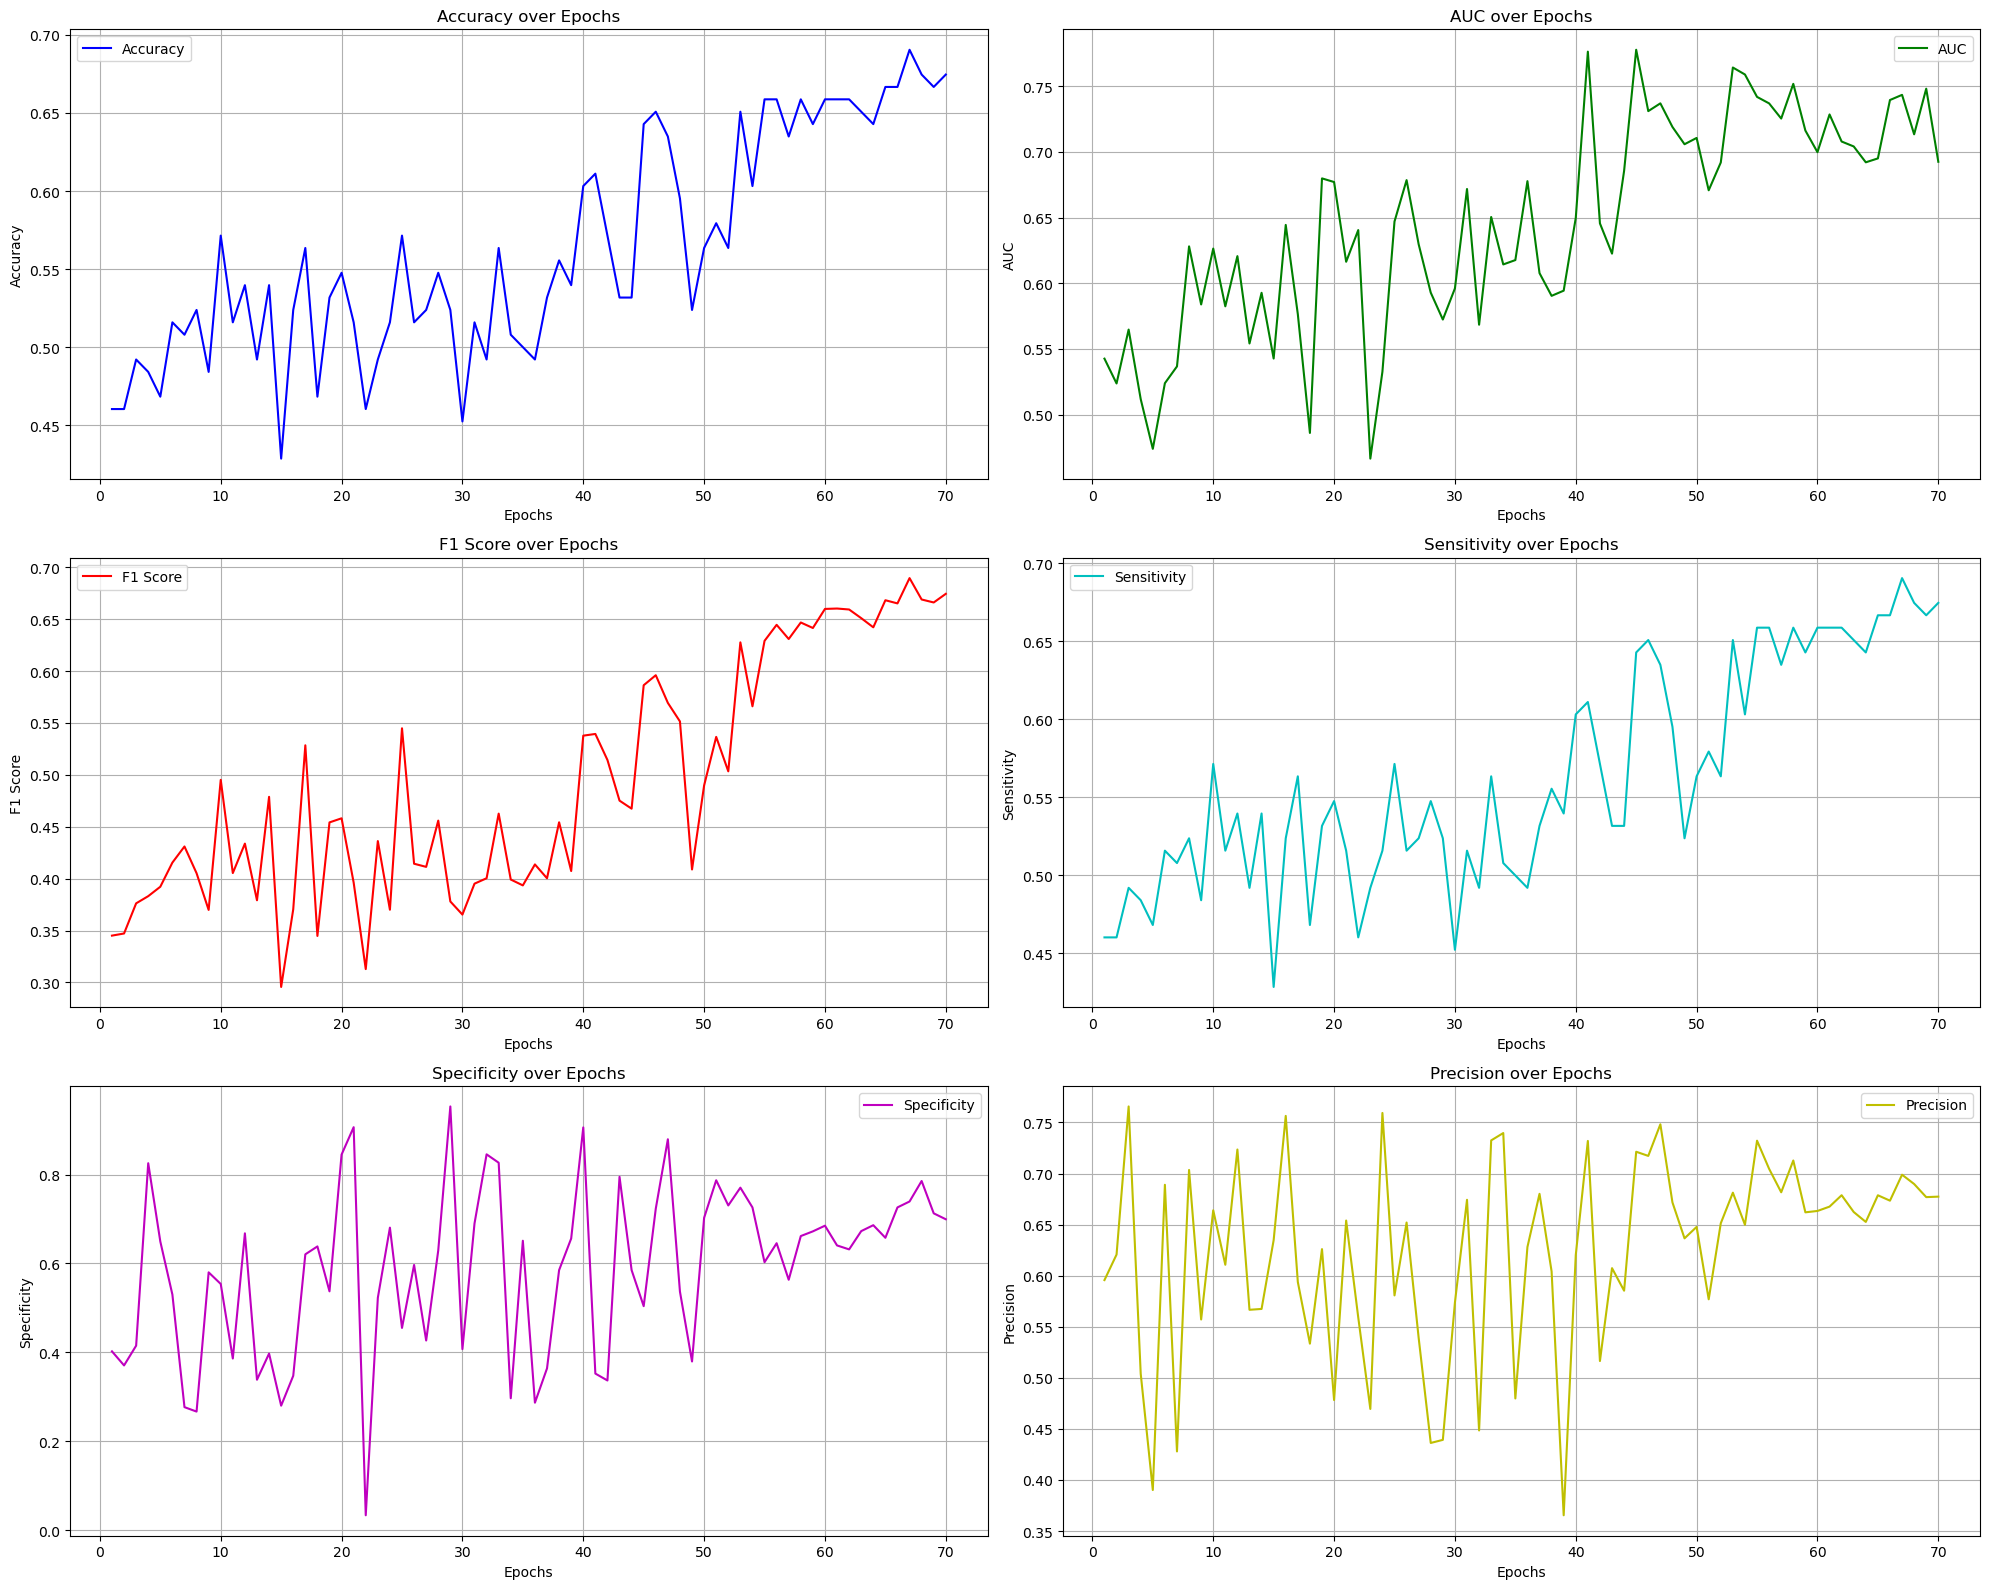

In [7]:
metrics = {
    'Accuracy': accuracy_avg,
    'AUC': auc_avg,
    'F1 Score': f1_avg,
    'Sensitivity': sen_avg,
    'Specificity': spe_avg,
    'Precision': pre_avg
}

colors = ['b', 'g', 'r', 'c', 'm', 'y']  # 为每个指标指定不同的颜色

plt.figure(figsize=(20, 16))
for idx, (metric_name, metric_values) in enumerate(metrics.items()):
    plt.subplot(3, 2, idx + 1)
    plt.plot(range(1, num_epochs + 1), metric_values, color=colors[idx], label=metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('validation_metrics_average.png')
plt.show()

In [9]:
accuracy_std

[0.04046840883803797,
 0.02969569354582494,
 0.011223917161691244,
 0.029695693545824946,
 0.07360014678964844,
 0.062492125984220735,
 0.07856742013183862,
 0.07776157913597392,
 0.04046840883803799,
 0.08908708063747478,
 0.04892392065848393,
 0.07360014678964848,
 0.04489566864676495,
 0.011223917161691244,
 0.0,
 0.05832118435198042,
 0.09187172145071607,
 0.06827242275430659,
 0.059391387091649865,
 0.051434449987363975,
 0.04046840883803797,
 0.08093681767607594,
 0.07856742013183862,
 0.07360014678964846,
 0.09720197391996738,
 0.06827242275430657,
 0.033671751485073675,
 0.07776157913597392,
 0.06734350297014738,
 0.019440394783993478,
 0.05611958580845616,
 0.05939138709164986,
 0.04892392065848395,
 0.1122391716169123,
 0.051434449987364,
 0.08979133729352987,
 0.06827242275430657,
 0.029695693545824915,
 0.029695693545824926,
 0.029695693545824964,
 0.12498425196844143,
 0.11825130496628046,
 0.029695693545824915,
 0.08093681767607597,
 0.0890870806374748,
 0.029695693545824

In [10]:
data = {
    'Epoch': [i + 1 for i in range(70)],
    'AUC': [f"{(auc_avg[i] * 100):.2f} ± {(auc_std[i] * 100):.2f}" for i in range(num_epochs)],
    'ACC': [f"{(accuracy_avg[i] * 100):.2f} ± {(accuracy_std[i] * 100):.2f}" for i in range(num_epochs)],
    'F1': [f"{(f1_avg[i] * 100):.2f} ± {(f1_std[i] * 100):.2f}" for i in range(num_epochs)],
    'SEN': [f"{(sen_avg[i] * 100):.2f} ± {(sen_std[i] * 100):.2f}" for i in range(num_epochs)],
    'SPE': [f"{(spe_avg[i] * 100):.2f} ± {(spe_std[i] * 100):.2f}" for i in range(num_epochs)],
    'PRE': [f"{(pre_avg[i] * 100):.2f} ± {(pre_std[i] * 100):.2f}" for i in range(num_epochs)]
}

In [11]:
import pandas as pd
# 转换为 DataFrame，方便显示
df = pd.DataFrame(data)
# 重新设置列为指标，行保持为 epoch
df = df.set_index('Epoch')

print(df)
    

                 AUC           ACC            F1           SEN            SPE  \
Epoch                                                                           
1       54.26 ± 4.59  46.03 ± 4.05  34.52 ± 5.58  46.03 ± 4.05  40.22 ± 42.58   
2       52.37 ± 9.45  46.03 ± 2.97  34.72 ± 3.41  46.03 ± 2.97  37.06 ± 41.10   
3      56.48 ± 10.14  49.21 ± 1.12  37.63 ± 1.64  49.21 ± 1.12  41.50 ± 41.37   
4       51.18 ± 6.83  48.41 ± 2.97  38.32 ± 5.85  48.41 ± 2.97  82.56 ± 19.08   
5       47.39 ± 1.92  46.83 ± 7.36  39.22 ± 9.57  46.83 ± 7.36  64.94 ± 31.29   
...              ...           ...           ...           ...            ...   
66      73.96 ± 2.06  66.67 ± 5.14  66.52 ± 5.41  66.67 ± 5.14   72.61 ± 1.76   
67      74.35 ± 1.96  69.05 ± 5.83  68.96 ± 6.11  69.05 ± 5.83   73.94 ± 2.24   
68      71.35 ± 6.26  67.46 ± 4.89  66.90 ± 4.17  67.46 ± 4.89  78.56 ± 11.34   
69      74.82 ± 3.20  66.67 ± 3.37  66.61 ± 3.70  66.67 ± 3.37   71.28 ± 2.87   
70      69.26 ± 6.28  67.46 

In [12]:

save_path = f"/root/Multimodal-Learning-with-Alternating-Unimodal-Adaptation-main/IK_TriAUT_CRNP/Metrics/Tri_AUT_CRNP.xlsx"
df.to_excel(save_path, index=True)